## Flood and Drought Risk Analysis Perception (RAP) Framework for India 

#### Contributors
**Team Lead**  Jennifer Marlon, Ph.D. **Team Members** Deepika Pingali, Surabhi Upadhyay, Emine Senkardesler, Pratyush Tripathy, Okikiola Michael Alegbeleye

Developed for the I-GUIDE Summer School on "Spatial AI for Extreme Events and Disaster Resilience" (August 4-8, 2025)

####  📊 Variables

**🎯 Dependent Variable**  
- *Survey-Based Drought Vulnerability Outcome*  
  (e.g., perceived flood risk, perceived drought risk)

**🔍 Covariates / Independent Variables**

**🧍 Individual-Level:**  Age, Gender, Education, Caste  

**🌐 District-Level**  
- News Media Webscraping for Floods
- VIIRS Nighttime Radiance 
- Alpha Earth Embeddings
- ERA5 Climate Data:  
  - Monthly Precipitation  
  - Monthly Temperature
  
#### 🤖 Modeling Scenarios
  
**Model 1:** Baseline model using only *individual-level demographic variables*  
(*Age, Gender, Education, Caste*)

**Model 2:** Includes *Model 1 + district-level physical features*  
(*VIIRS Radiance, ERA5 Precipitation & Temperature, News Mentions*)

**Model 3:** Model 1 + *Alpha Earth Embeddings* 

**Model 4:** Advanced model integrating *Alpha Earth Embeddings* with all other covariates

In [9]:
# import required libraries
import pandas as pd

In [ ]:
import requests
from tqdm import tqdm
import pandas as pd

# File URL
url = "https://zenodo.org/records/16781519/files/RAR_TEAM1_FinalCleanedData_250807.csv?download=1"
output_file = "RAR_TEAM1_FinalCleanedData_250807.csv"

# Stream download with progress bar
response = requests.get(url, stream=True)
total_size = int(response.headers.get('content-length', 0))
block_size = 1024  # 1 KB

with open(output_file, 'wb') as file, tqdm(
    desc="Downloading CSV",
    total=total_size,
    unit='B',
    unit_scale=True,
    unit_divisor=1024
) as bar:
    for data in response.iter_content(block_size):
        file.write(data)
        bar.update(len(data))

# Load into pandas
try:
    df = pd.read_csv(output_file)
    print("File loaded successfully!")
    print(df.head())
except Exception as e:
    print(f"Could not load the file: {e}")


In [2]:
# read the data
data_df = pd.read_csv('250807_FinalCleanedData_PT.csv')
data_df['di_code'] = data_df['di_code'].astype(int)

# filter the data
print(data_df.keys())
data_df.head()

Index(['Unnamed: 0.1', 'caseid', 'weight', 'wave', 'state', 'district',
       'urban', 'gender', 'age', 'caste',
       ...
       'A63_p2', 'A63_p90', 'A63_p95', 'A63_p98', 'A63_sum', 'A63_mean',
       'A63_min', 'A63_max', 'A63_count', 'split'],
      dtype='object', length=608)


,Unnamed: 0.1,caseid,weight,wave,state,district,urban,gender,age,caste,...,A63_p2,A63_p90,A63_p95,A63_p98,A63_sum,A63_mean,A63_min,A63_max,A63_count,split
0,0,10001,0.840547,2024,NE,East Khasi Hills,Urban,Male,18-29,Scheduled Castes/Tribes,...,-0.124567,0.103406,0.124567,0.147697,43582.604336,0.012406,-0.267958,0.327812,3519450.0,train
1,1,10002,1.360886,2024,UT,Leh,Rural,Female,45+,Scheduled Castes/Tribes,...,-0.206936,0.093564,0.141730,0.267958,-117536.992772,-0.024344,-0.318893,0.346021,4837249.0,train
2,2,10002,1.360886,2024,UT,Leh,Rural,Female,45+,Scheduled Castes/Tribes,...,-0.221453,0.103406,0.130165,0.160000,-248714.921995,-0.038288,-0.327812,0.318893,6508506.0,train
3,3,10003,0.640417,2024,UT,Daman & Diu,Rural,Male,30-44,Other Castes,...,0.032541,0.221453,0.236463,0.244152,10633.937208,0.124858,-0.051734,0.355309,86148.0,train
4,4,10003,0.640417,2024,UT,Daman & Diu,Rural,Male,30-44,Other Castes,...,-0.022207,0.206936,0.244152,0.259900,4060.501217,0.087937,-0.113741,0.355309,47012.0,train


## Define column names for different models

In [5]:
# create keys for all four models
features_list_model1 = ['age', 'gender', 'urban', 'caste', 'di_code']
features_list_model2 = features_list_model1 + ['mean_monthly_avg_rd_MD', 'precip_sum_mm', 'precip_mean_mm', 'mean_tmax', 'district_flood_sentiment', 'state_flood_sentiment']
features_list_model3 = features_list_model1 + [
    f'{var}_{metric}'
    for var in sorted(set([
        data.split('_')[0] 
        for data in data_df.loc[:, data_df.columns.str.startswith('A')].keys()
    ]))
    for metric in ['min', 'p2', 'mean', 'p98', 'max', 'sum', 'count']
]
features_list_model4 = list(set(features_list_model2 + features_list_model3))

flood_y_key = 'n7fy23_recode'
drought_y_key = 'n7dy23_recode'

## Prepare data for the model

In [6]:
%%time

%%time
from sklearn.preprocessing import LabelEncoder

# Encode categorical variables FIRST (on full dataset)
data_encoded = data_df.copy()
encoders = {}

for var in ['age', 'gender', 'urban', 'caste', 'di_code']:
    encoders[var] = LabelEncoder()
    data_encoded[var] = encoders[var].fit_transform(data_df[var])

# Split the encoded data (general variables)
X_train_encoded = data_encoded[data_encoded['split'] == 'train']
X_test_encoded = data_encoded[data_encoded['split'] == 'test']
y_train = data_encoded[data_encoded['split'] == 'train'][flood_y_key]
y_test = data_encoded[data_encoded['split'] == 'test'][flood_y_key]

print(f"X_train_encoded shape: {X_train_encoded.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test_encoded shape: {X_test_encoded.shape}")
print(f"y_test shape: {y_test.shape}")

X_train_encoded shape: (1431, 608)
y_train shape: (1431,)
X_test_encoded shape: (250, 608)
y_test shape: (250,)
CPU times: user 337 ms, sys: 202 ms, total: 539 ms
Wall time: 1.73 s
CPU times: user 337 ms, sys: 203 ms, total: 540 ms
Wall time: 1.73 s


In [7]:
import time
import os
import joblib
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

def train_models_with_features(X_train_encoded, X_test_encoded, y_train, y_test, 
                               features_list, model_name_suffix=""):
    """
    Train multiple models with specified features and save results
    
    Parameters:
    -----------
    X_train_encoded : DataFrame
        Training features (encoded)
    X_test_encoded : DataFrame  
        Test features (encoded)
    y_train : array-like
        Training target
    y_test : array-like
        Test target
    features_list : list
        List of feature names to use
    model_name_suffix : str
        Suffix to add to saved model files (e.g., "model1", "model2")
    
    Returns:
    --------
    tuple: (metrics_df, trained_models, feature_importance_results)
    """
    
    print(f"{'='*60}")
    print(f"Training models with {len(features_list)} features")
    if model_name_suffix:
        print(f"Model suffix: {model_name_suffix}")
    print(f"{'='*60}")
    
    # Extract features
    X_train_subset = X_train_encoded[features_list]
    X_test_subset = X_test_encoded[features_list]
    
    # Define models and parameters
    models = {
        'RandomForest': (RandomForestClassifier(random_state=42), {
            'n_estimators': [10, 50, 100, 200], 'max_depth': [10, 20, None]}),
        
        'GradientBoosting': (GradientBoostingClassifier(random_state=42), {
            'n_estimators': [100, 200], 'learning_rate': [0.1, 0.2], 'max_depth': [3, 5]}),
        
        'LogisticRegression': (LogisticRegression(random_state=42, max_iter=1000), {
            'C': [0.1, 1, 10], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']})
    }
    
    results = []
    trained_models = {}
    feature_importance_results = {}
    
    # Train each model
    for name, (model, params) in models.items():
        print(f"Training {name}...")
        start = time.time()
        
        grid = GridSearchCV(model, params, cv=5, scoring='accuracy')
        grid.fit(X_train_subset, y_train)
        
        # Store the best estimator
        trained_models[name] = grid.best_estimator_
        
        # Make predictions
        train_pred = grid.predict(X_train_subset)
        test_pred = grid.predict(X_test_subset)
        train_proba = grid.predict_proba(X_train_subset)[:, 1]
        test_proba = grid.predict_proba(X_test_subset)[:, 1]
        
        # Calculate metrics
        results.append({
            'Model': name,
            'Train_Accuracy': accuracy_score(y_train, train_pred),
            'Test_Accuracy': accuracy_score(y_test, test_pred),
            'Train_Precision': precision_score(y_train, train_pred),
            'Test_Precision': precision_score(y_test, test_pred),
            'Train_Recall': recall_score(y_train, train_pred),
            'Test_Recall': recall_score(y_test, test_pred),
            'Train_F1': f1_score(y_train, train_pred),
            'Test_F1': f1_score(y_test, test_pred),
            'Train_AUC': roc_auc_score(y_train, train_proba),
            'Test_AUC': roc_auc_score(y_test, test_proba)
        })
        
        print(f"{name} - Test Acc: {results[-1]['Test_Accuracy']:.3f}, Test AUC: {results[-1]['Test_AUC']:.3f}")
        print(f"Time: {time.time()-start:.1f}s\n")
    
    # Create metrics DataFrame
    metrics_df = pd.DataFrame(results)
    
    # Print results nicely
    print("FINAL RESULTS:")
    display_df = metrics_df.round(3).set_index('Model').T
    print(display_df)
    print()
    
    # Extract feature importance
    print("Extracting feature importance...")
    for model_name, trained_model in trained_models.items():
        importance_df = get_feature_importance(trained_model, model_name, features_list)
        if importance_df is not None:
            feature_importance_results[model_name] = importance_df
            print(f"{model_name} - Top 5 features:")
            print(importance_df.head(5)[['Feature', 'Importance']].to_string(index=False))
            print()
    
    # Save everything
    save_results(metrics_df, trained_models, feature_importance_results, 
                 features_list, model_name_suffix)
    
    return metrics_df, trained_models, feature_importance_results

def get_feature_importance(model, model_name, feature_names):
    """Extract feature importance based on model type"""
    
    if hasattr(model, 'feature_importances_'):
        # Tree-based models
        importance = model.feature_importances_
        importance_type = 'Gini/Entropy Importance'
        
    elif hasattr(model, 'coef_'):
        # Linear models
        importance = np.abs(model.coef_[0])
        importance_type = 'Coefficient Magnitude'
        
    else:
        print(f"Feature importance not available for {model_name}")
        return None
    
    # Create feature importance DataFrame
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance,
        'Model': model_name,
        'Importance_Type': importance_type
    }).sort_values('Importance', ascending=False)
    
    return feature_importance_df

def save_results(metrics_df, trained_models, feature_importance_results, 
                 features_list, model_name_suffix):
    """Save all results to files"""
    
    # Create directory
    save_dir = 'saved_models'
    os.makedirs(save_dir, exist_ok=True)
    
    # Create file suffix
    suffix = f"_{model_name_suffix}" if model_name_suffix else ""
    
    # Save models
    for model_name, trained_model in trained_models.items():
        joblib.dump(trained_model, f'{save_dir}/{model_name}_model{suffix}.pkl')
    
    # Save feature importance
    for model_name, importance_df in feature_importance_results.items():
        importance_df.to_csv(f'{save_dir}/{model_name}_feature_importance{suffix}.csv', index=False)
    
    # Save metrics and features
    metrics_df.to_csv(f'{save_dir}/model_metrics{suffix}.csv', index=False)
    joblib.dump(features_list, f'{save_dir}/feature_list{suffix}.pkl')
    
    print(f"Results saved with suffix '{suffix}' in '{save_dir}/' directory")




In [8]:
%%time

# Train with first set of features
metrics1, models1, importance1 = train_models_with_features(
    X_train_encoded[features_list_model1], X_test_encoded[features_list_model1], y_train, y_test, 
    features_list_model1, "model1"
)

# Train with second set of features  
metrics2, models2, importance2 = train_models_with_features(
    X_train_encoded[features_list_model2], X_test_encoded[features_list_model2], y_train, y_test,
    features_list_model2, "model2"
)

# Train with third set of features
metrics3, models3, importance3 = train_models_with_features(
    X_train_encoded[features_list_model3], X_test_encoded[features_list_model3], y_train, y_test,
    features_list_model3, "model3"
)

# Train with fourth set of features
metrics4, models4, importance4 = train_models_with_features(
    X_train_encoded[features_list_model4], X_test_encoded[features_list_model4], y_train, y_test,
    features_list_model4, "model4"
)

Training models with 5 features
Model suffix: model1
Training RandomForest...
RandomForest - Test Acc: 0.556, Test AUC: 0.522
Time: 9.2s

Training GradientBoosting...
GradientBoosting - Test Acc: 0.596, Test AUC: 0.596
Time: 6.9s

Training LogisticRegression...
LogisticRegression - Test Acc: 0.560, Test AUC: 0.548
Time: 0.1s

FINAL RESULTS:
Model            RandomForest  GradientBoosting  LogisticRegression
Train_Accuracy          0.852             0.678               0.558
Test_Accuracy           0.556             0.596               0.560
Train_Precision         0.864             0.665               0.579
Test_Precision          0.629             0.616               0.613
Train_Recall            0.857             0.794               0.614
Test_Recall             0.599             0.830               0.680
Train_F1                0.860             0.724               0.596
Test_F1                 0.613             0.707               0.645
Train_AUC               0.938             0.7

## Make the plots

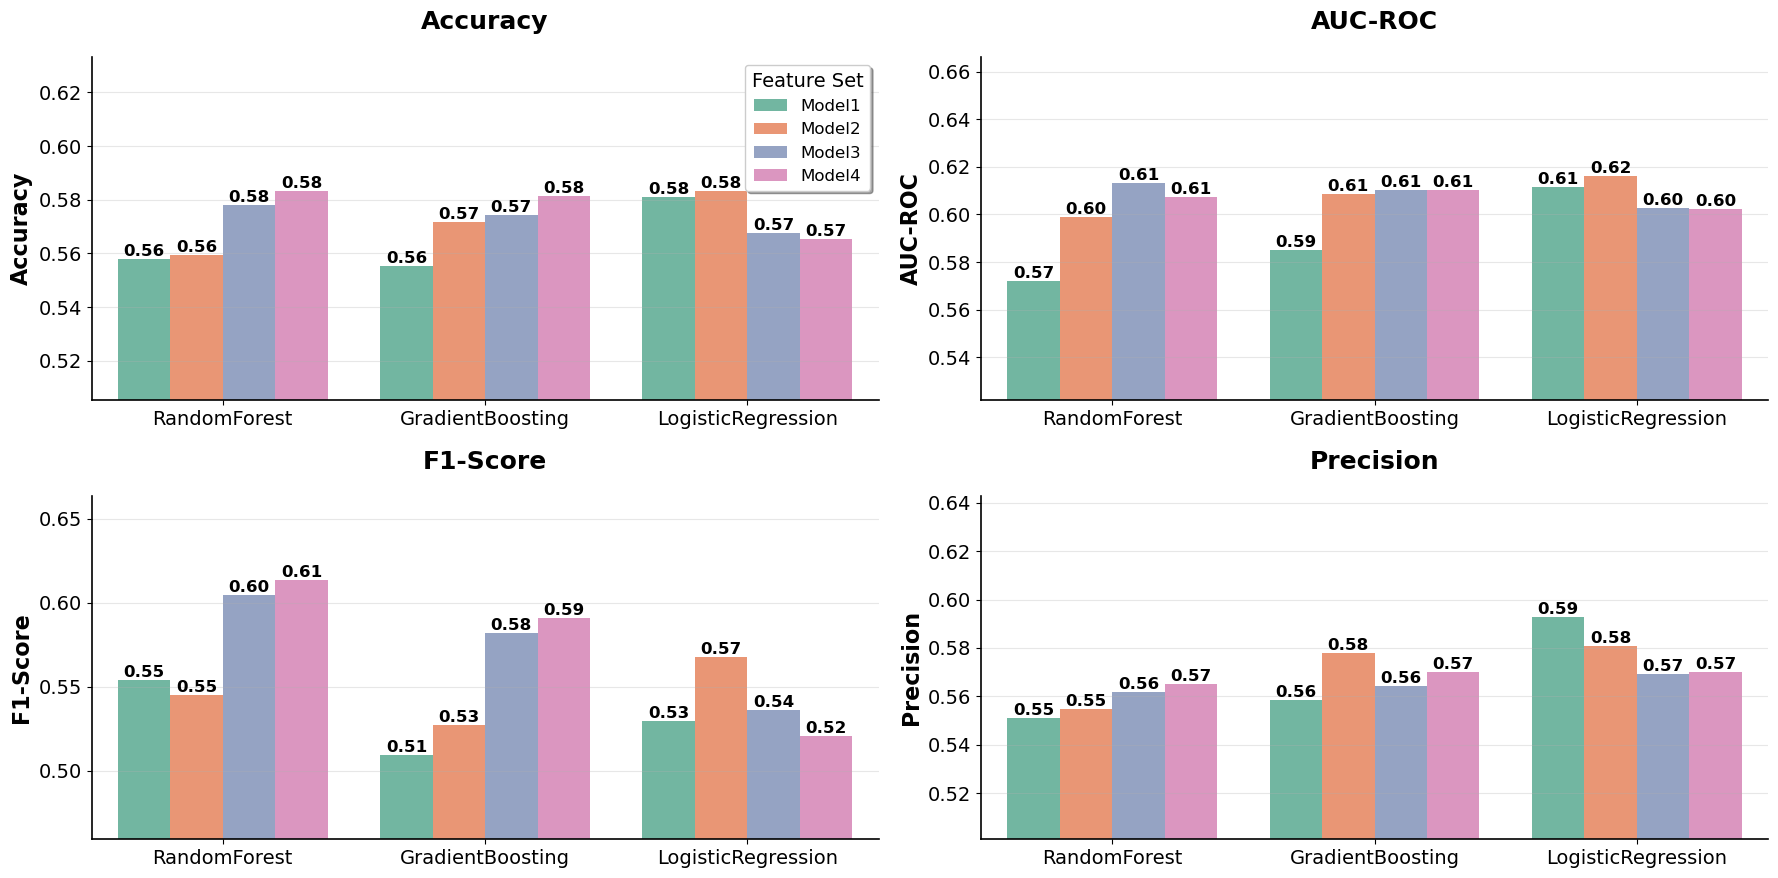


PERFORMANCE SUMMARY TABLE

RandomForest:
Feature_Set  Test_Accuracy  Test_AUC  Test_F1  Test_Precision
     Model1           0.56      0.57     0.55            0.55
     Model2           0.56      0.60     0.55            0.55
     Model3           0.58      0.61     0.60            0.56
     Model4           0.58      0.61     0.61            0.57

GradientBoosting:
Feature_Set  Test_Accuracy  Test_AUC  Test_F1  Test_Precision
     Model1           0.56      0.59     0.51            0.56
     Model2           0.57      0.61     0.53            0.58
     Model3           0.57      0.61     0.58            0.56
     Model4           0.58      0.61     0.59            0.57

LogisticRegression:
Feature_Set  Test_Accuracy  Test_AUC  Test_F1  Test_Precision
     Model1           0.58      0.61     0.53            0.59
     Model2           0.58      0.62     0.57            0.58
     Model3           0.57      0.60     0.54            0.57
     Model4           0.57      0.60     0.52     

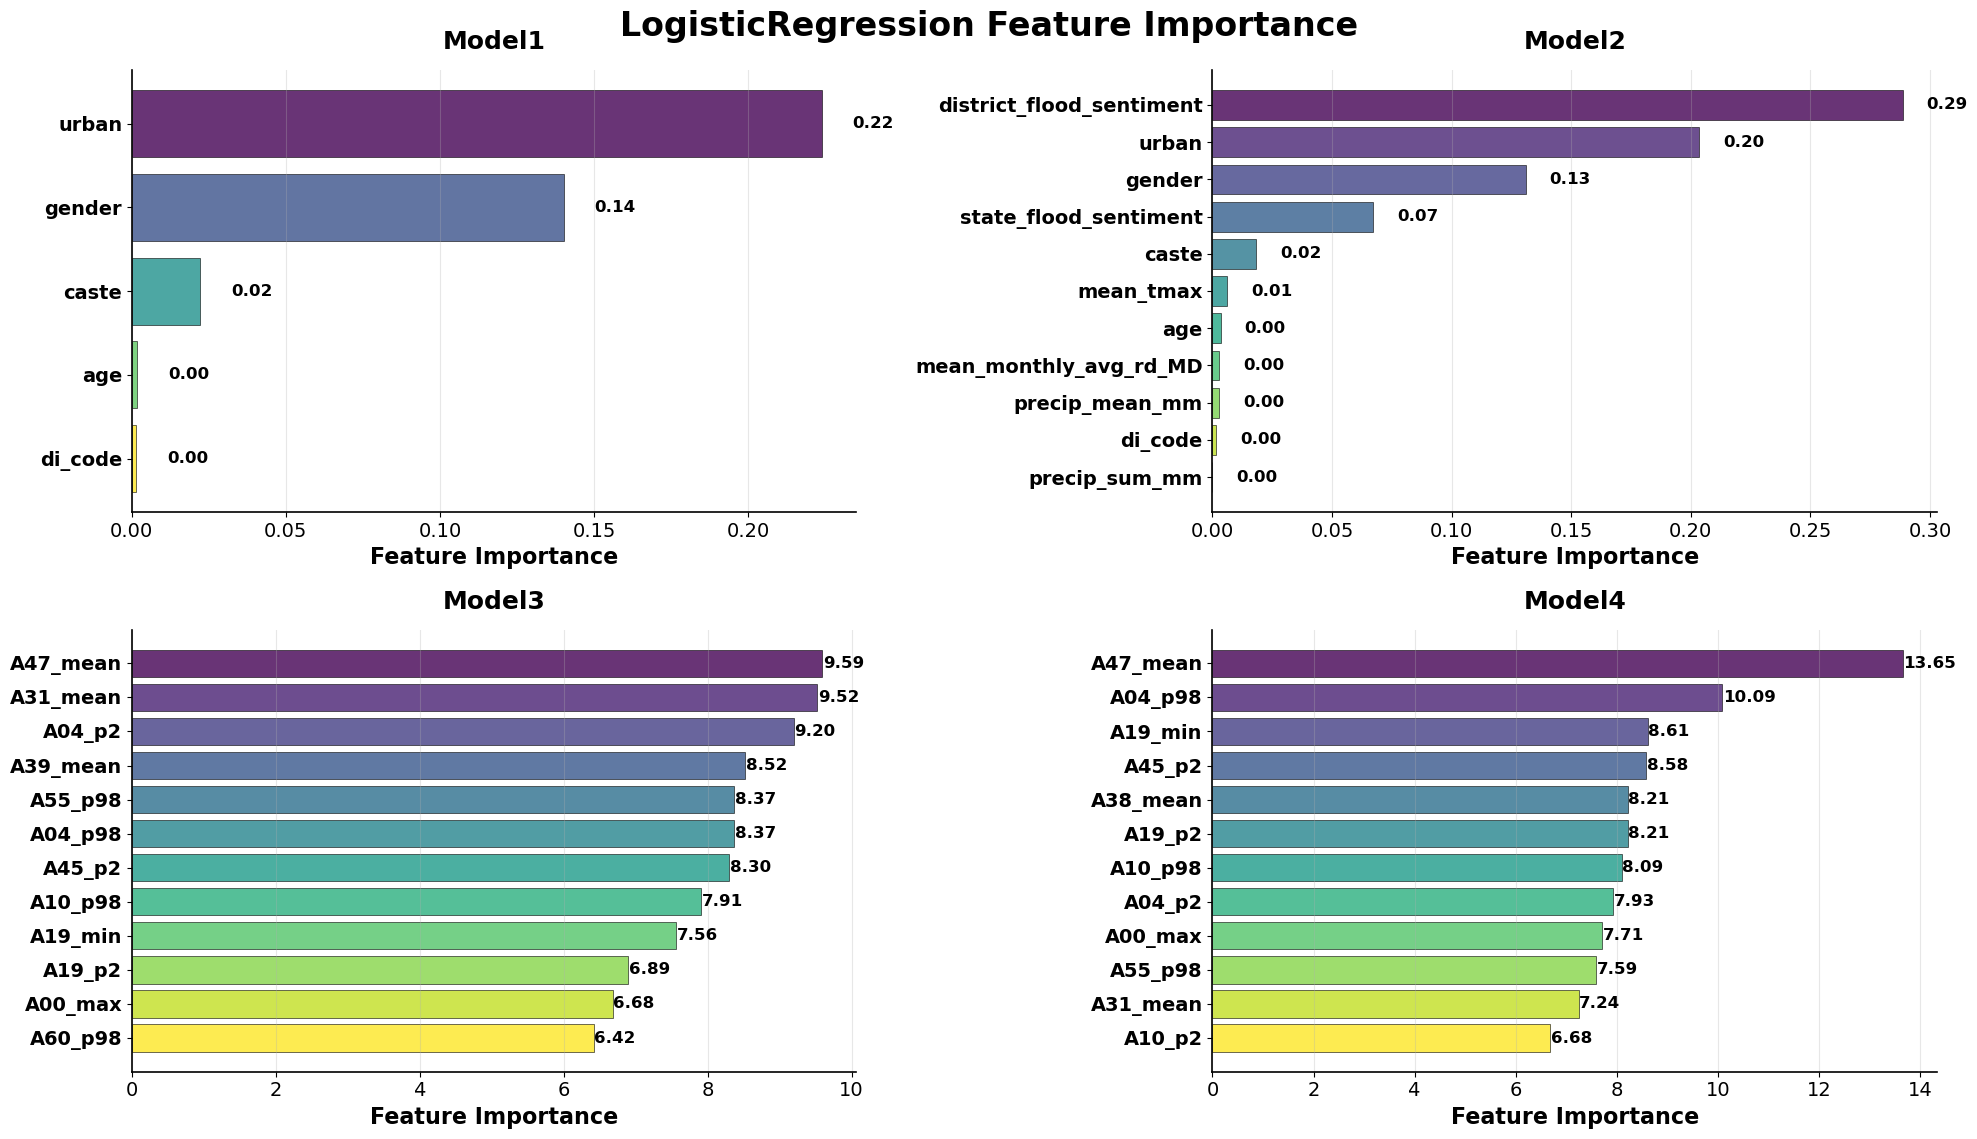

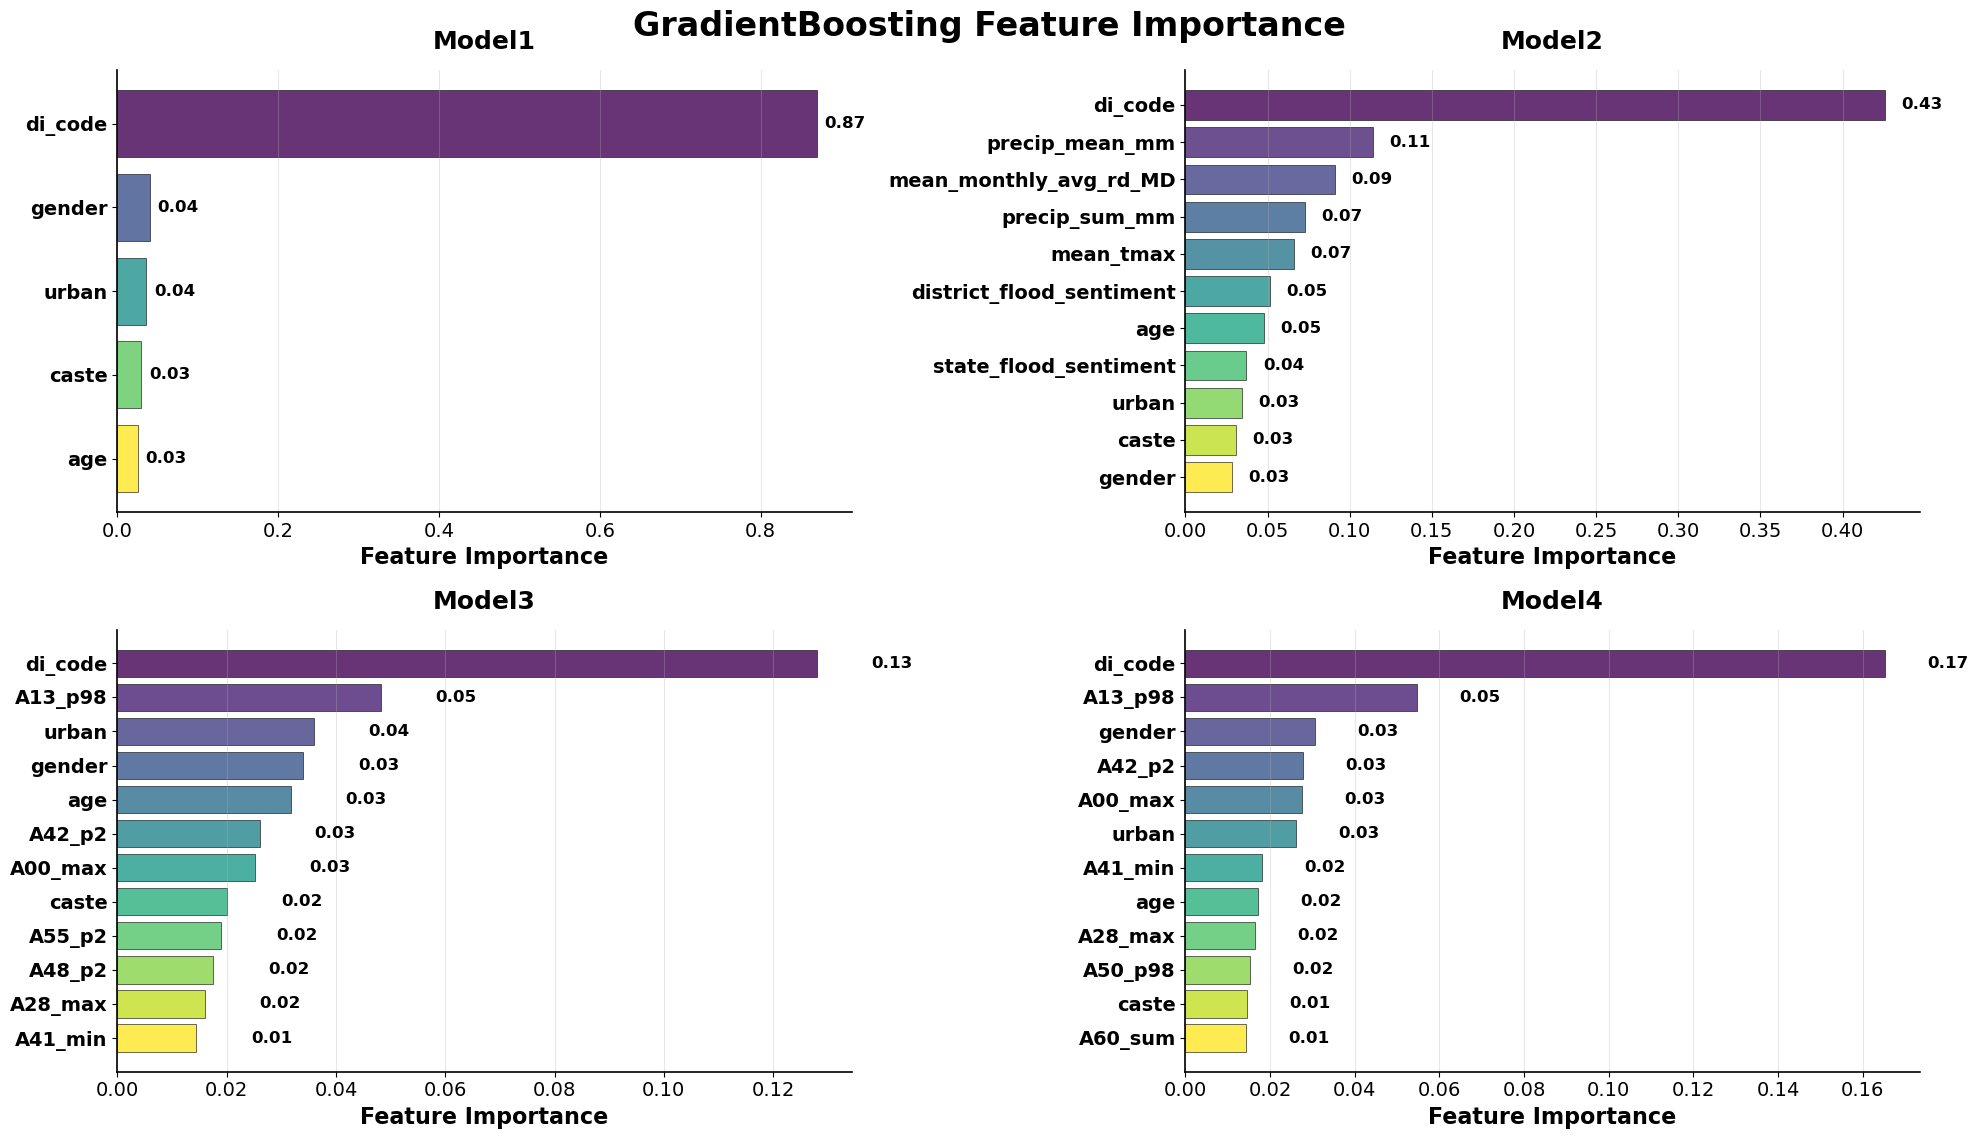

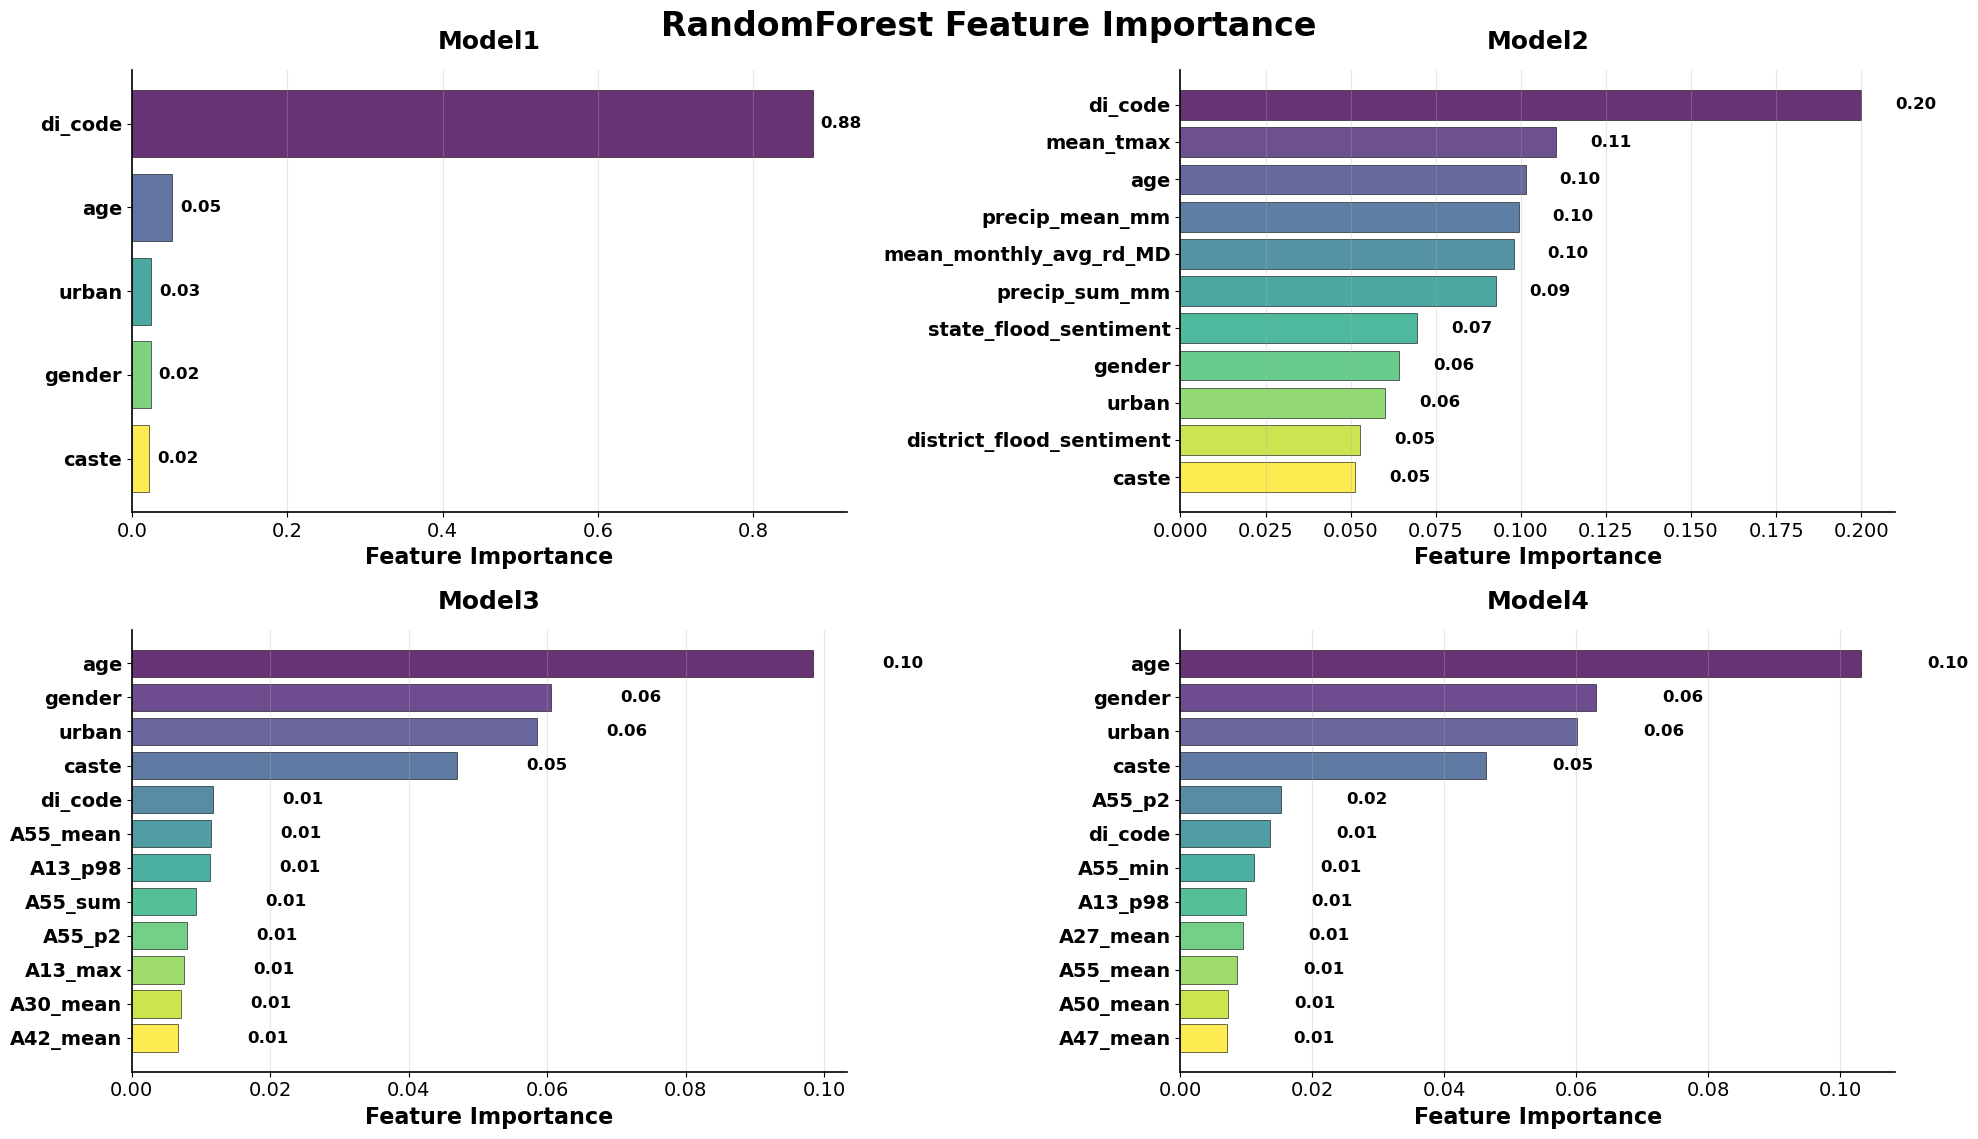

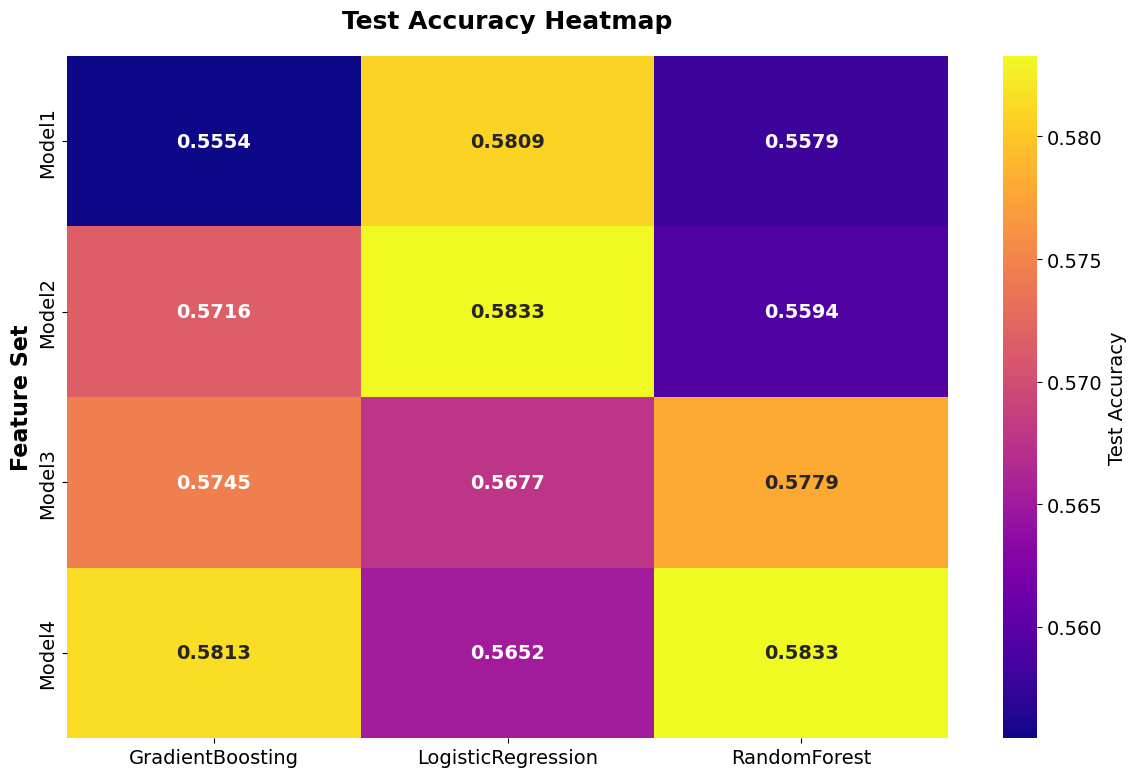


EXECUTIVE SUMMARY
Overall Best Model: LogisticRegression (Model2) - Accuracy: 0.5833

Detailed Accuracy Results:
Model        GradientBoosting  LogisticRegression  RandomForest
Feature_Set                                                    
Model1                 0.5554              0.5809        0.5579
Model2                 0.5716              0.5833        0.5594
Model3                 0.5745              0.5677        0.5779
Model4                 0.5813              0.5652        0.5833


In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set professional style
plt.rcParams['font.family'] = 'DejaVu Sans'  # Changed from Arial
plt.rcParams['font.size'] = 14  # Increased base font size
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['axes.spines.top'] = False     # Remove top spine
plt.rcParams['axes.spines.right'] = False   # Remove right spine
sns.set_palette("Set2")

def plot_accuracy_metrics_slide(metrics_list, model_suffixes, save_path=None):
    """
    SLIDE 1: Model Performance Comparison
    Professional accuracy metrics visualization
    """
    
    # Combine data
    combined_data = []
    for metrics_df, suffix in zip(metrics_list, model_suffixes):
        temp_df = metrics_df.copy()
        temp_df['Feature_Set'] = suffix
        combined_data.append(temp_df)
    
    combined_df = pd.concat(combined_data, ignore_index=True)
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(18, 9))
    
    # Metrics to plot
    metrics = [
        ('Test_Accuracy', 'Accuracy', axes[0,0]),
        ('Test_AUC', 'AUC-ROC', axes[0,1]),
        ('Test_F1', 'F1-Score', axes[1,0]),
        ('Test_Precision', 'Precision', axes[1,1])
    ]
    
    for metric_col, metric_name, ax in metrics:
        # Create bar plot
        bars = sns.barplot(data=combined_df, x='Model', y=metric_col, hue='Feature_Set', ax=ax)
        
        # Customize appearance
        ax.set_title(f'{metric_name}', fontsize=18, fontweight='bold', pad=20)
        ax.set_xlabel('', fontsize=16, fontweight='bold')  # Removed 'Model Type'
        ax.set_ylabel(metric_name, fontsize=16, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')
        
        # Increase tick label sizes
        ax.tick_params(axis='both', which='major', labelsize=14)
        
        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Add value labels on bars
        for container in bars.containers:
            bars.bar_label(container, fmt='%.2f', fontsize=12, fontweight='bold')
        
        # Set consistent y-axis limits for better comparison
        y_min = max(0, combined_df[metric_col].min() - 0.05)
        y_max = min(1, combined_df[metric_col].max() + 0.05)
        ax.set_ylim(y_min, y_max)
        
        # Style legend - move to top right
        if metric_name == 'Accuracy':  # Only show legend once
            ax.legend(title='Feature Set', title_fontsize=14, fontsize=12, 
                     loc='upper right', frameon=True, fancybox=True, shadow=True)
        else:
            ax.get_legend().remove()
    
    plt.tight_layout()
    
    # Save with high DPI if path provided
    if save_path:
        plt.savefig(f'{save_path}_performance.png', dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # Print summary table
    print("\n" + "="*80)
    print("PERFORMANCE SUMMARY TABLE")
    print("="*80)
    
    summary_cols = ['Test_Accuracy', 'Test_AUC', 'Test_F1', 'Test_Precision']
    for model in combined_df['Model'].unique():
        print(f"\n{model}:")
        model_data = combined_df[combined_df['Model'] == model][['Feature_Set'] + summary_cols]
        print(model_data.round(2).to_string(index=False))

def plot_feature_importance_slide(feature_importance_dict, model_suffixes, save_path=None):
    """
    SLIDE 2: Feature Importance Analysis
    Professional feature importance visualization
    """
    
    models = ['LogisticRegression', 'GradientBoosting', 'RandomForest']
    
    for model in models:
        fig, axes = plt.subplots(2, 2, figsize=(20, 12))
        fig.suptitle(f'{model} Feature Importance', 
                     fontsize=24, fontweight='bold', y=0.95)
        axes = axes.flatten()
        
        for i, suffix in enumerate(model_suffixes):
            ax = axes[i]
            
            if suffix in feature_importance_dict and model in feature_importance_dict[suffix]:
                importance_df = feature_importance_dict[suffix][model]
                top_features = importance_df.head(12)  # Show top 12 for better visibility
                
                # Create horizontal bar plot
                colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))
                bars = ax.barh(range(len(top_features)), top_features['Importance'], 
                              color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
                
                # Customize appearance
                ax.set_yticks(range(len(top_features)))
                ax.set_yticklabels(top_features['Feature'], fontsize=13, fontweight='bold')
                ax.set_xlabel('Feature Importance', fontsize=16, fontweight='bold')
                ax.set_title(f'{suffix}', fontsize=18, fontweight='bold', pad=15)
                ax.invert_yaxis()
                ax.grid(True, alpha=0.3, axis='x')
                
                # Increase tick label sizes
                ax.tick_params(axis='both', which='major', labelsize=14)
                
                # Remove top and right spines
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                
                # Add value labels on bars
                for j, bar in enumerate(bars):
                    width = bar.get_width()
                    ax.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
                           f'{width:.2f}', ha='left', va='center', 
                           fontsize=12, fontweight='bold')
                
                # Removed ranking numbers as requested
                
            else:
                ax.text(0.5, 0.5, f'No data available\nfor {suffix}', 
                       transform=ax.transAxes, ha='center', va='center', 
                       fontsize=16, fontweight='bold', color='gray')
                ax.set_title(f'{suffix}', fontsize=18, fontweight='bold')
                # Remove spines for empty plots too
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        
        # Save with high DPI if path provided
        if save_path:
            plt.savefig(f'{save_path}_{model}_importance.png', dpi=300, bbox_inches='tight')
        
        plt.show()

def plot_model_comparison_slide(metrics_list, model_suffixes, save_path=None):
    """
    SLIDE 3: Test Accuracy Heatmap Only
    Professional heatmap visualization
    """
    
    # Combine data
    combined_data = []
    for metrics_df, suffix in zip(metrics_list, model_suffixes):
        temp_df = metrics_df.copy()
        temp_df['Feature_Set'] = suffix
        combined_data.append(temp_df)
    
    combined_df = pd.concat(combined_data, ignore_index=True)
    
    # Create figure with single plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    # Test Accuracy heatmap
    pivot_acc = combined_df.pivot(index='Feature_Set', columns='Model', values='Test_Accuracy')
    
    # Use a colormap with better variation
    sns.heatmap(pivot_acc, annot=True, cmap='plasma', 
                fmt='.4f', ax=ax, cbar_kws={'label': 'Test Accuracy'},
                annot_kws={'fontsize': 14, 'fontweight': 'bold'})
    
    ax.set_title('Test Accuracy Heatmap', fontsize=18, fontweight='bold', pad=20)
    ax.set_xlabel('', fontsize=16, fontweight='bold')  # Removed 'Model Type'
    ax.set_ylabel('Feature Set', fontsize=16, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    plt.tight_layout()
    
    # Save with high DPI if path provided
    if save_path:
        plt.savefig(f'{save_path}_comparison.png', dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # Print executive summary
    print("\n" + "="*80)
    print("EXECUTIVE SUMMARY")
    print("="*80)
    print(f"Overall Best Model: {combined_df.loc[combined_df['Test_Accuracy'].idxmax(), 'Model']} "
          f"({combined_df.loc[combined_df['Test_Accuracy'].idxmax(), 'Feature_Set']}) "
          f"- Accuracy: {combined_df['Test_Accuracy'].max():.4f}")
    
    # Print detailed accuracy table
    print("\nDetailed Accuracy Results:")
    pivot_table = combined_df.pivot(index='Feature_Set', columns='Model', values='Test_Accuracy')
    print(pivot_table.round(4))

# Usage for presentation:
# Create presentation-ready plots with high DPI export
metrics_list = [metrics1, metrics2, metrics3, metrics4]
model_suffixes = ['Model1', 'Model2', 'Model3', 'Model4']
feature_importance_dict = {
    'Model1': importance1,
    'Model2': importance2, 
    'Model3': importance3,
    'Model4': importance4
}

# SLIDE 1: Performance Metrics (saves as 'plots_performance.png')
plot_accuracy_metrics_slide(metrics_list, model_suffixes, save_path='plots')

# SLIDE 2: Feature Importance (saves as 'plots_RandomForest_importance.png', etc.)
plot_feature_importance_slide(feature_importance_dict, model_suffixes, save_path='plots')

# SLIDE 3: Comprehensive Comparison (saves as 'plots_comparison.png')
plot_model_comparison_slide(metrics_list, model_suffixes, save_path='plots')